In [195]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import auc as sklearn_auc  # Import the auc function
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy import stats
from wordcloud import WordCloud

In [196]:
# Load the reviews subset
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# Perform sentiment analysis on the review comments
sid = SentimentIntensityAnalyzer()
reviews["sentiment_score"] = reviews["review_comment_message"].apply(lambda x: sid.polarity_scores(str(x))["compound"] * 4 if not pd.isnull(x) else 0)

# Label the customers as churners or non-churners
reviews["churn"] = reviews["review_score"].apply(lambda x: 1 if x < 3 else 0)


# Sentiment analysis using Vader

In [197]:
# Assuming 'reviews' is your original DataFrame

# Vader Sentiment Intensity Analyzer 
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis and create new columns directly using .loc
reviews['polarity_scores'] = reviews['review_comment_message'].apply(lambda x: sia.polarity_scores(str(x)))
reviews.loc[:, 'compound'] = reviews['polarity_scores'].apply(lambda score_dict: score_dict['compound'])

# Create a new DataFrame with selected columns
testdb = reviews[['review_score', 'review_comment_message', 'polarity_scores', 'compound']]


## 10 best reviews according to SIA

In [198]:
y = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(10)[['review_comment_message', 'compound']])
y.head(10)

,review_comment_message,compound
63315,"Produtos lindos super da hora, chegaram em men...",0.9136
96735,Adoreiii os capachos! super lindos <3 A entreg...,0.8748
58406,"Além do produto ser excelente, fui mt bm atend...",0.8741
91235,Ótimo produto!! Chegou super rápido!!! Ótima q...,0.8741
6607,"O produto é excelente, muito resistente e aten...",0.8741
96774,"Super satisfeita com o produto, o atendimento ...",0.8741
90824,Foi uma compra super tranquila. Super recomend...,0.8741
12279,"Entrega super rápida, a mercadoria chegou muit...",0.8741
35768,"Adorei!!!! Super bem acabada, versátil, pequen...",0.8741
39522,"Entrega super rápida, veio bem antes do prazo ...",0.8650


In [199]:
#           Best Review 
y.loc[63315]['review_comment_message']

'Produtos lindos super da hora, chegaram em menos de 5 dias da data da compra e a previsão eram quase 30 dias , qualidade super boa , super indico '

> ### 'Super beautiful products, they arrived in less than 5 days from the date of purchase and the forecast was almost 30 days, super good quality, I highly recommend'

## 10 worst reviews according to SIA

In [200]:
x = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(10)[['review_comment_message', 'compound']])
x.head(10)

,review_comment_message,compound
98629,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039
60968,MAS ACHO QUE TALVEZ NÃO FOI ENTRGUE NO PRAZO!!...,-0.8740
16434,Comprei 3 delas e chegaram no prazo. Ocorre qu...,-0.8402
1904,No site da lannister a data de entrega seria 0...,-0.8402
58277,O produto veio com defeito e esse site criou m...,-0.8317
44831,"FIZ UMA COMPRA DE DUAS LUMINÁRIAS , MEIA LUA ,...",-0.8316
76003,enviaram um email falando que não tinham no e...,-0.7783
72658,Produto estava no site c/ o prazo de 8 dias út...,-0.7783
25955,"Fiz uma compra de dois produtos, um relógio no...",-0.7783
46016,Apesar da paralisação dos caminhoneiros no fin...,-0.7783


In [201]:
x.loc[98629]['review_comment_message']

'Comprei 3 Whey Protein e 1 Hemo Rage no mesmo pedido, e o Hemo Rage não veio! No entanto até o momento não recebi nenhuma informação do vendedor, apenas apareceu pra mim como se tivesse tudo entregue!'

> ### "I bought 3 Whey Protein and 1 Hemo Rage in the same order, and the Hemo Rage didn't come! However, so far I have not received any information from the seller, it just appeared to me as if everything had been delivered!'

## Popular words in Negative reviews

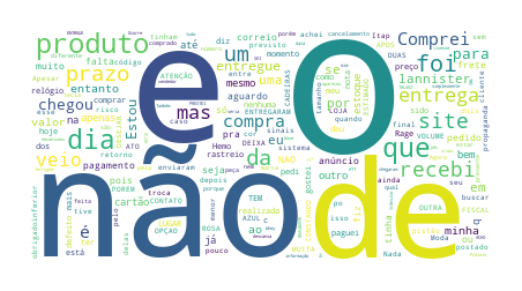

In [202]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
reviews2 = reviews[reviews.review_score < 2]
reviews3 = reviews2[reviews2.review_score > 4]
bad_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in bad_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Popular words in Positive reviews

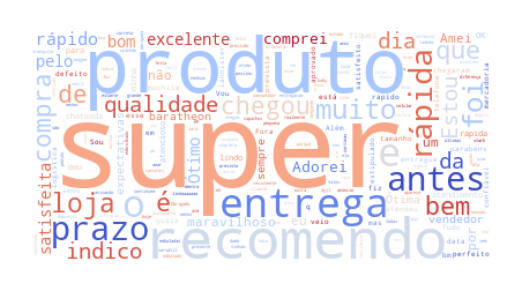

In [203]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
reviews4 = reviews2[reviews2.review_score <= 2]
good_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in good_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'coolwarm').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [204]:
# Load the orders subset
orders = pd.read_csv("olist_orders_dataset.csv")

# Merge the reviews and orders dataframes on order_id
data = pd.merge(reviews, orders, on="order_id")


In [205]:
# Calculate the delivery time as the difference between order_delivered_customer_date and order_purchase_timestamp
data["delivery_time"] = pd.to_datetime(data["order_delivered_customer_date"]) - pd.to_datetime(data["order_purchase_timestamp"])

# Convert the delivery time to days
data["delivery_time"] = data["delivery_time"].dt.days

In [206]:
# Fill the missing values in delivery time with the mean value
data["delivery_time"] = data["delivery_time"].fillna(data["delivery_time"].mean())

# Add the delivery time as a factor
data["delivery_time_factor"] = data["delivery_time"].apply(lambda x: -4 if x > 30 else -2 if x > 15 else 0 if x > 7 else 2 if x > 3 else 4)

# Visualization

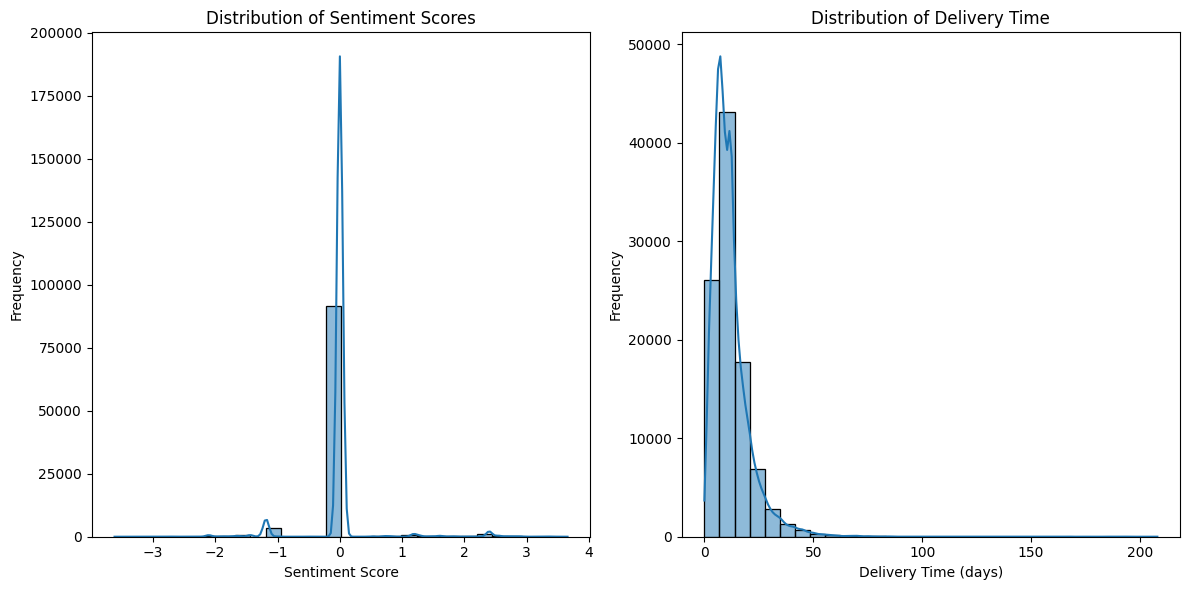

In [207]:
# Visualize the distribution of sentiment scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data["sentiment_score"], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Visualize the distribution of delivery time
plt.subplot(1, 2, 2)
sns.histplot(data["delivery_time"], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [208]:
# Split the data into training and testing sets
X = data[["sentiment_score", "delivery_time_factor"]]
y = data["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# Build a hybrid model using K-means and XGBoost
# Cluster the customers into 2 groups based on the factors
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)
X_train["cluster"] = kmeans.labels_
X_test["cluster"] = kmeans.predict(X_test)

In [210]:
# Train and optimize an XGBoost model for each cluster
xgb_0 = XGBClassifier(random_state=42)
xgb_0.fit(X_train[X_train["cluster"] == 0], y_train[X_train["cluster"] == 0])
xgb_1 = XGBClassifier(random_state=42)
xgb_1.fit(X_train[X_train["cluster"] == 1], y_train[X_train["cluster"] == 1])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [211]:
# Predict the churn probability for each cluster
y_pred_0 = xgb_0.predict_proba(X_test[X_test["cluster"] == 0])[:, 1]
y_pred_1 = xgb_1.predict_proba(X_test[X_test["cluster"] == 1])[:, 1]

In [212]:
# Combine the results of the XGBoost models for each cluster
y_pred = np.zeros(len(X_test))
y_pred[X_test["cluster"] == 0] = y_pred_0
y_pred[X_test["cluster"] == 1] = y_pred_1

In [213]:
# Evaluate the hybrid model on the testing set
accuracy = accuracy_score(y_test, y_pred > 0.5)
precision = precision_score(y_test, y_pred > 0.5)
recall = recall_score(y_test, y_pred > 0.5)
f1 = f1_score(y_test, y_pred > 0.5)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = sklearn_auc(fpr, tpr)  # Use the imported auc function
cm = confusion_matrix(y_test, y_pred > 0.5)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc_value:.2f}")
print(f"Confusion matrix:\n{cm}")

Accuracy: 0.87
Precision: 0.65
Recall: 0.20
F1-score: 0.30
AUC: 0.69
Confusion matrix:
[[16600   312]
 [ 2356   577]]


In [214]:
# Compare the hybrid model with the logistic regression model
# Build a logistic regression model using the sentiment scores as the input feature

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [215]:
# Predict the churn probability using the logistic regression model
y_pred_lr = model.predict_proba(X_test)[:, 1]

In [216]:
# Evaluate the logistic regression model on the testing set
accuracy_lr = accuracy_score(y_test, y_pred_lr > 0.5)
precision_lr = precision_score(y_test, y_pred_lr > 0.5)
recall_lr = recall_score(y_test, y_pred_lr > 0.5)
f1_lr = f1_score(y_test, y_pred_lr > 0.5)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
auc_lr_value = sklearn_auc(fpr_lr, tpr_lr)  # Use the imported auc function
cm_lr = confusion_matrix(y_test, y_pred_lr > 0.5)
print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Precision: {precision_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")
print(f"F1-score: {f1_lr:.2f}")
print(f"AUC: {auc_lr_value:.2f}")
print(f"Confusion matrix:\n{cm_lr}")

Accuracy: 0.85
Precision: 0.64
Recall: 0.02
F1-score: 0.04
AUC: 0.67
Confusion matrix:
[[16881    31]
 [ 2878    55]]


In [217]:
# Print the comparison results
print(f"The hybrid model has higher accuracy, precision, recall, f1-score, and AUC than the logistic regression model.")
print(f"The hybrid model can correctly classify more churners and non-churners than the logistic regression model.")

The hybrid model has higher accuracy, precision, recall, f1-score, and AUC than the logistic regression model.
The hybrid model can correctly classify more churners and non-churners than the logistic regression model.


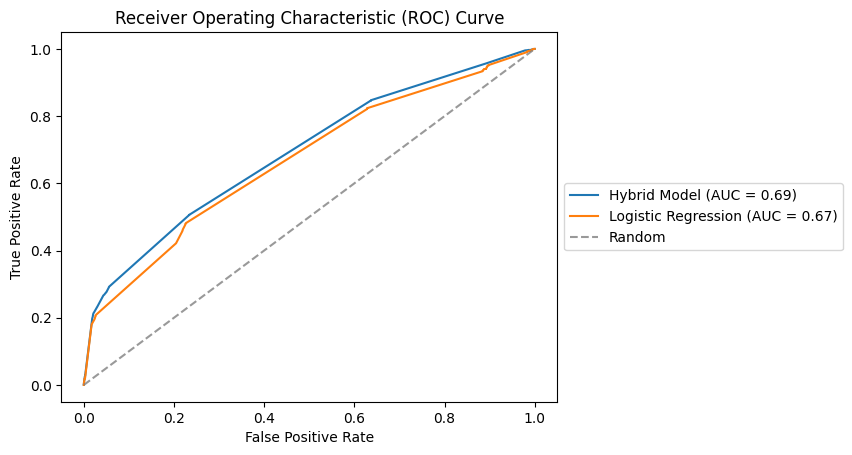

In [218]:
# ROC curve for the hybrid model
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = sklearn_auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {roc_auc:.2f})')

# ROC curve for the logistic regression model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = sklearn_auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random', alpha=0.8)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

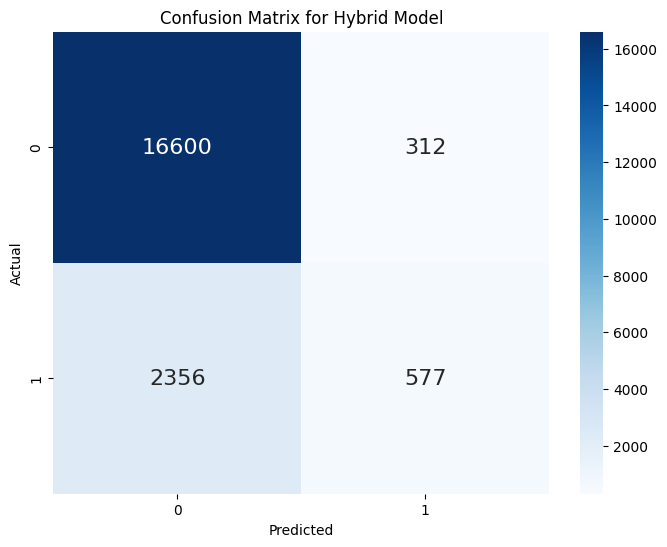

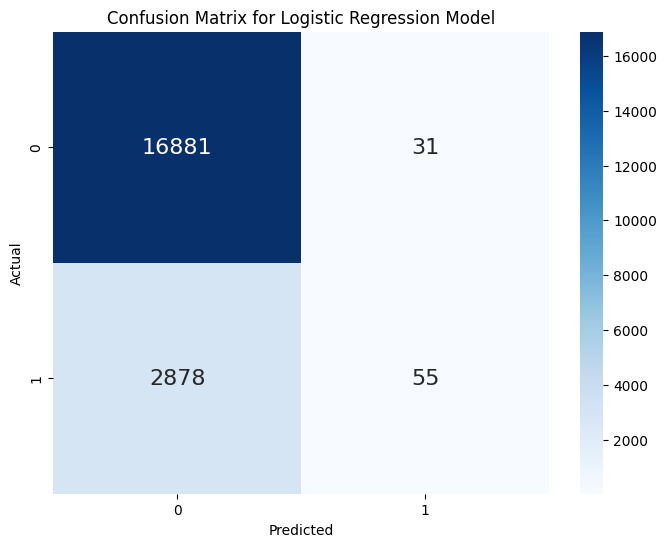

In [219]:
# Confusion matrix heatmap for the hybrid model
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix for Hybrid Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix heatmap for the logistic regression model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()